# WIP Disclaimer

In [1]:
%load_ext autoreload
%autoreload 2

import time

*Note*: Development and testing was done on a n1-standard-4 (4 vCPUs, 15 GB memory) Google Cloud instance with 1 NVIDIA Tesla K80 GPU.

## The Basics

First, let's generate some sample vectors.

In [2]:
import numpy as np

# 500,000 1,024-dimensional vectors
d = 1_024
n_vectors = 500_000

X = np.random.random((n_vectors, d)).astype('float32')

In [3]:
from interactive_index import InteractiveIndex

You can configure your index by specifying a config yaml file or by overriding the config defaults with keyword arguments.

An example yaml file is provided in the repo, and the defaults can be seen in `config.py`:

```python3
CONFIG_DEFAULTS = {
    'd': 1_024,
    'n_centroids': 32,
    'n_probes': 4,
    'vectors_per_index': 10_000,
    'tempdir': '/tmp/',
    'use_gpu': True,
    'use_float16': True,
    'use_float16_quantizer': True,
    'use_precomputed_codes': False,
    
    # Transformation
    'transform': None,
    'transform_args': None,

    # Encoding
    'encoding': 'Flat',
    'encoding_args': None
}
```

For convenience I will use these defaults and explicitly specify the fields I want to override.

In [5]:
index = InteractiveIndex(d=d, n_centroids=1_024, vectors_per_index=25_000)

The index has been initialized and written to `/tmp/trained.index`, though it knows the clustering layer has not be trained yet.

In [6]:
index.is_trained

False

### Training

The first thing that needs to be done now is to train the clustering algorithm (in order to define the centroids used when adding vectors).

It's an open question of how to best do this, but you just want a training set that is representative of the full dataset. It is recommended to use at least `39 * n_centroids` training vectors. In this case that would be `39 * 1,024 = 39,936` or around 40,000 points.

Training cannot be done incrementally, and vectors cannot be added before training the indexed is trained.

In [7]:
train_inds = np.random.choice(np.arange(X.shape[0]), 40_000)
X_train = X[train_inds]

In [8]:
start = time.time()
index.train(X_train)
end = time.time()
print(f'Training took {end - start:.3} seconds')

Training took 2.39 seconds


### Adding

Now we can add vectors altogether or in batches.

In [9]:
print(f'# partial indexes: {index.n_indexes}, # total vectors: {index.n_vectors}')

# Say we get them 10,000 at a time
batch_size = 25_000
for i in range(0, n_vectors, batch_size):
    start = time.time()
    index.add(X[i:i + batch_size])
    end = time.time()
    print(f'Adding 25,000 vectors took {end - start:.3} seconds')
    print(f'# partial indexes: {index.n_indexes}, # total vectors: {index.n_vectors}')

# partial indexes: 0, # total vectors: 0
Adding 25,000 vectors took 0.871 seconds
# partial indexes: 1, # total vectors: 25000
Adding 25,000 vectors took 0.874 seconds
# partial indexes: 2, # total vectors: 50000
Adding 25,000 vectors took 0.798 seconds
# partial indexes: 3, # total vectors: 75000
Adding 25,000 vectors took 0.822 seconds
# partial indexes: 4, # total vectors: 100000
Adding 25,000 vectors took 0.814 seconds
# partial indexes: 5, # total vectors: 125000
Adding 25,000 vectors took 0.81 seconds
# partial indexes: 6, # total vectors: 150000
Adding 25,000 vectors took 0.803 seconds
# partial indexes: 7, # total vectors: 175000
Adding 25,000 vectors took 0.805 seconds
# partial indexes: 8, # total vectors: 200000
Adding 25,000 vectors took 0.467 seconds
# partial indexes: 9, # total vectors: 225000
Adding 25,000 vectors took 0.467 seconds
# partial indexes: 10, # total vectors: 250000
Adding 25,000 vectors took 0.465 seconds
# partial indexes: 11, # total vectors: 275000
Addi

The add times have a good bit of variance, and though I have some hypotheses, I am not certain what accounts for all of it. I explore the times in more depth later in this file.

For `train()`, `add()`, or `query()` you can also pass in a file name for the source vectors that is the output of `np.ndarray.tofile()`.

### Merging

Before querying, you need to merge the partial indexes. This can be done incrementally, so if you can merge again after adding more vectors.

In [10]:
start = time.time()
index.merge_partial_indexes()
end = time.time()
print(f'Merging {index.n_indexes} indexes took {end - start:.3} seconds')

Merging 20 indexes took 2.43 seconds


The merged data for this index was 1.91 GB.

### Querying

In order to query you simply pass in your query template vector, list of vectors, or file name containing either, the number of results you want, and optionally the number of clusters you want to probe, which will override the setting from the config for this call only.

In [11]:
xq = np.random.random(d).astype('float32')

In [12]:
k = 50

start = time.time()
dists, inds = index.query(xq, k, n_probes=4)
end = time.time()
print(f'Querying {k} neighbors took {end - start:.3} seconds')

print(dists)
print(inds)

Querying 50 neighbors took 0.0668 seconds
[[143.56714 146.48721 148.57648 149.133   149.20522 149.29927 149.41249
  149.57698 149.57904 149.73349 149.9116  149.9194  150.18794 150.51785
  150.855   150.96259 151.0063  151.25485 151.31705 151.35455 151.41133
  151.68216 151.7627  151.89145 151.94998 151.95447 152.0358  152.1112
  152.11159 152.18768 152.41693 152.51703 152.5299  152.59009 152.60391
  152.60693 152.64178 152.69919 152.70947 152.75543 152.78625 152.84143
  152.89627 152.96805 153.1636  153.17975 153.18666 153.22882 153.23654
  153.29716]]
[[280647 373567 400199 213979 180785 103039 152939 155279 283513 123265
  310511 473007 224772 178337 279908 338158 412549 154197 180398 240354
  333034 322706  93687  63479 197788  40173 396707 347887 414200 379242
  412375  40176 336495  83355  42790  30880 302787 429216 193239 226971
   93983 147031 477798  29252 261898 464635 438889 415900 390836 153605]]


## Performance Analysis

### Training

The first step we want to analyze is training, with respect to the following variables:
- CPU vs. GPU
- Number of training points
- Number of dimensions
- Number of centroids
- Using PQ encoding of different sizes

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from interactive_index import InteractiveIndex

In [7]:
d = 1_024
X_train = np.random.random((500_000, d)).astype('float32')

n_train_sizes = [5_000, 10_000, 25_000, 50_000, 100_000, 250_000, 500_000]
n_train_times = [[], []]
for use_gpu in [1, 0]:
    for n_train in n_train_sizes:
        index = InteractiveIndex(d=d, n_centroids=1_024, use_gpu=bool(use_gpu))
        start = time.time()
        index.train(X_train[:n_train])
        end = time.time()
        print(f'{n_train}: {end - start:.3} seconds')
        n_train_times[use_gpu].append(end - start)

5000: 1.32 seconds
10000: 0.741 seconds
25000: 1.35 seconds
50000: 2.28 seconds
100000: 4.03 seconds
250000: 9.57 seconds
500000: 12.3 seconds
5000: 8.07 seconds
10000: 15.9 seconds
25000: 39.7 seconds
50000: 79.1 seconds
100000: 1.58e+02 seconds
250000: 3.95e+02 seconds
500000: 4.17e+02 seconds


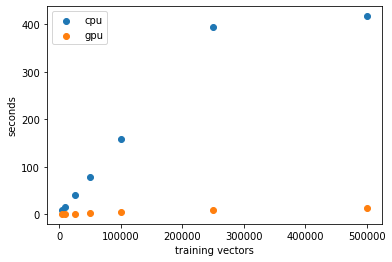

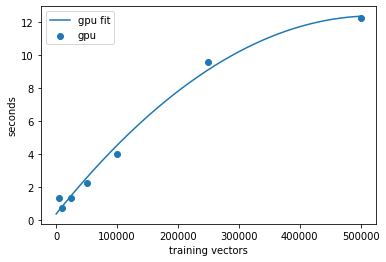

coefs: -4.400850378494866e-11 4.5962506253576e-05 0.38373546965489647


In [46]:
plt.scatter(n_train_sizes, n_train_times[0], label='cpu')
plt.scatter(n_train_sizes, n_train_times[1], label='gpu')
plt.ylabel('seconds')
plt.xlabel('training vectors')
plt.legend()
plt.show()

plt.scatter(n_train_sizes, n_train_times[1], label='gpu')
a1, b1, c1 = np.polyfit(n_train_sizes, n_train_times[1], deg=2)
plt.plot(np.arange(n_train_sizes[-1]), c1 + np.arange(n_train_sizes[-1]) * b1 + np.arange(n_train_sizes[-1])**2 * a1 , label='gpu fit')
plt.ylabel('seconds')
plt.xlabel('training vectors')
plt.legend()
plt.show()
print('coefs:', a1, b1, c1)

In [26]:
n_train = 50_000
d_sizes = [128, 256, 512, 1_024, 2_048, 4_096]
d_times = []
for d in d_sizes:
    X_train = np.random.random((n_train, d)).astype('float32')
    index = InteractiveIndex(d=d, n_centroids=1_024, use_gpu=True)
    start = time.time()
    index.train(X_train)
    end = time.time()
    print(f'{d}: {end - start:.3} seconds')
    d_times.append(end - start)

128: 0.558 seconds
256: 0.798 seconds
512: 1.26 seconds
1024: 2.29 seconds
2048: 4.02 seconds
4096: 7.95 seconds


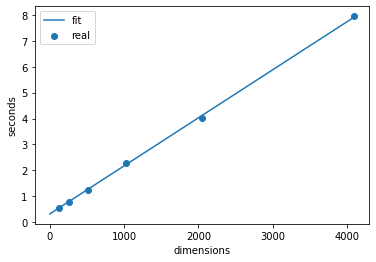

coefs: 0.0018549600871598877 0.3187148903139787


In [47]:
plt.scatter(d_sizes, d_times, label='real')
a1, b1 = np.polyfit(d_sizes, d_times, deg=1)
plt.plot(np.arange(d_sizes[-1]), b1 + a1 * np.arange(d_sizes[-1]), label='fit')
plt.ylabel('seconds')
plt.xlabel('dimensions')
plt.legend()
plt.show()
print('coefs:', a1, b1)

In [32]:
n_train = 50_000
d = 1_024
n_centroids_sizes = [16, 32, 64, 128, 256, 512, 1_024, 2_048, 4_096]
n_centroids_times = []
for n_centroids in n_centroids_sizes:
    X_train = np.random.random((n_train, d)).astype('float32')
    index = InteractiveIndex(d=d, n_centroids=n_centroids, use_gpu=True)
    start = time.time()
    index.train(X_train)
    end = time.time()
    print(f'{n_centroids}: {end - start:.3} seconds')
    n_centroids_times.append(end - start)

16: 0.574 seconds
32: 0.693 seconds
64: 0.896 seconds
128: 1.37 seconds
256: 1.76 seconds
512: 1.94 seconds
1024: 2.32 seconds
2048: 3.07 seconds
4096: 4.65 seconds


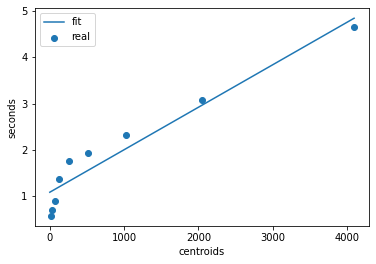

coefs: 0.0009182352600960944 1.085731888559542


In [48]:
plt.scatter(n_centroids_sizes, n_centroids_times, label='real')
a1, b1 = np.polyfit(n_centroids_sizes, n_centroids_times, deg=1)
plt.plot(np.arange(n_centroids_sizes[-1]), b1 + a1 * np.arange(n_centroids_sizes[-1]), label='fit')
plt.ylabel('seconds')
plt.xlabel('centroids')
plt.legend()
plt.show()
print('coefs:', a1, b1)

### Adding

Relevent variables:
- Number of vectors being added
- Number of dimensions
- Number of centroids
- Using PQ encoding of different sizes

### Querying

- Number of query vectors
- Number of dimensions
- Number of probes
- Using PQ encoding of different sizes